In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from AmtrackDataCollector import AmtrackDataCollector

collector = AmtrackDataCollector("my_train_data.json")

raw_data = collector.get_train_data()

print(f"Number of train groups: {len(raw_data)}")

first_train_key = list(raw_data.keys())[0]
first_train = raw_data[first_train_key][0]

print(f"Keys in first train: {list(first_train.keys())}")
print(f"Station values in first train: {(first_train['stations'][0].keys())}")

Using recently saved data.
Number of train groups: 148
Keys in first train: ['routeName', 'trainNum', 'trainNumRaw', 'trainID', 'lat', 'lon', 'trainTimely', 'iconColor', 'textColor', 'stations', 'heading', 'eventCode', 'eventTZ', 'eventName', 'origCode', 'originTZ', 'origName', 'destCode', 'destTZ', 'destName', 'trainState', 'velocity', 'statusMsg', 'createdAt', 'updatedAt', 'lastValTS', 'objectID', 'provider', 'providerShort', 'onlyOfTrainNum', 'alerts']
Station values in first train: dict_keys(['name', 'code', 'tz', 'bus', 'schArr', 'schDep', 'arr', 'dep', 'arrCmnt', 'depCmnt', 'status', 'stopIconColor', 'platform'])


In [13]:
train_records = []
for train_number, train_list in raw_data.items():
  for train in train_list:
    train_record = {
      'train_number': train_number,
      'route_name': train.get('routeName', ''),
      'train_id': train.get('trainID', ''),
      'lat': train.get('lat'),
      'lon': train.get('lon'),
      'heading': train.get('heading', ''),
      'velocity': train.get('velocity'),
      'train_state': train.get('trainState', ''),
      'status_msg': train.get('statusMsg', ''),
      'origin_code': train.get('origCode', ''),
      'dest_code': train.get('destCode', ''),
      'num_stations': len(train.get('stations', []))
    }
    train_records.append(train_record)

trains_df = pd.DataFrame(train_records)
print("TRAINS DataFrame:")
print(trains_df.head())
print(f"Shape: {trains_df.shape}")

TRAINS DataFrame:
  train_number       route_name train_id        lat         lon heading  \
0            2   Sunset Limited      2-3  32.857114 -111.725315      SE   
1            3  Southwest Chief      3-3  38.064177 -103.040407       W   
2            3  Southwest Chief      3-2  34.539285 -117.295415      SE   
3            4  Southwest Chief      4-2  39.081657  -94.605583       N   
4            4  Southwest Chief      4-3  35.138345 -111.063312      SE   

    velocity train_state status_msg origin_code dest_code  num_stations  
0  79.212379      Active                    LAX       NOL            22  
1  78.895477      Active                    CHI       LAX            32  
2  35.138531      Active                    CHI       LAX            32  
3   0.053687      Active                    LAX       CHI            32  
4  86.991943      Active                    LAX       CHI            32  
Shape: (158, 12)


In [14]:
station_records = []
for train_number, train_list in raw_data.items():
  for train in train_list:
    route_name = train.get('routeName', '')
    train_id = train.get('trainID', '')
    
    for station in train.get('stations', []):
      station_record = {
        'train_number': train_number,
        'train_id': train_id,
        'route_name': route_name,
        'station_name': station.get('name', ''),
        'station_code': station.get('code', ''),
        'scheduled_arrival': station.get('schArr'),
        'actual_arrival': station.get('arr'),
        'scheduled_departure': station.get('schDep'),
        'actual_departure': station.get('dep'),
        'status': station.get('status', ''),
        'timezone': station.get('tz', ''),
      }
      station_records.append(station_record)

stations_df = pd.DataFrame(station_records)

time_columns = ['scheduled_arrival', 'actual_arrival', 'scheduled_departure', 'actual_departure']
for col in time_columns:
  stations_df[col] = pd.to_datetime(stations_df[col], errors='coerce', utc=True)

print("\nSTATIONS DataFrame:")
print(stations_df.head())
print(f"Shape: {stations_df.shape}")



STATIONS DataFrame:
  train_number train_id      route_name       station_name station_code  \
0            2      2-3  Sunset Limited  Los Angeles Union          LAX   
1            2      2-3  Sunset Limited             Pomona          POS   
2            2      2-3  Sunset Limited            Ontario          ONA   
3            2      2-3  Sunset Limited       Palm Springs          PSN   
4            2      2-3  Sunset Limited               Yuma          YUM   

          scheduled_arrival            actual_arrival  \
0 2025-08-04 05:00:00+00:00 2025-08-04 05:00:00+00:00   
1 2025-08-04 05:41:00+00:00 2025-08-04 05:45:00+00:00   
2 2025-08-04 05:54:00+00:00 2025-08-04 05:56:00+00:00   
3 2025-08-04 07:36:00+00:00 2025-08-04 07:23:00+00:00   
4 2025-08-04 09:47:00+00:00 2025-08-04 09:46:00+00:00   

        scheduled_departure          actual_departure    status  \
0 2025-08-04 05:00:00+00:00 2025-08-04 05:00:00+00:00  Departed   
1 2025-08-04 05:41:00+00:00 2025-08-04 05:47:00+00:

Departure delays: 0    0.0
1    6.0
2    6.0
3    0.0
4    4.0
Name: departure_delay_minutes, dtype: float64
Arrival delays: 0     0.0
1     4.0
2     2.0
3   -13.0
4    -1.0
Name: arrival_delay_minutes, dtype: float64


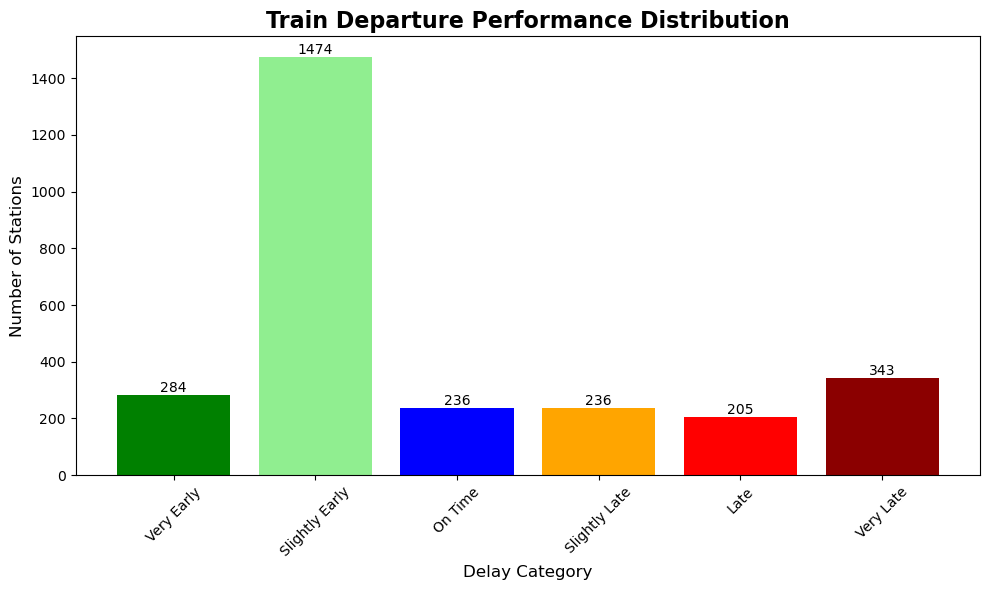

In [15]:
stations_df["departure_delay_minutes"] = (stations_df['actual_departure'] - stations_df['scheduled_departure']).dt.total_seconds() / 60
stations_df["arrival_delay_minutes"] = (stations_df['actual_arrival'] - stations_df['scheduled_arrival']).dt.total_seconds() / 60

print(f"Departure delays: {stations_df.departure_delay_minutes.head()}")
print(f"Arrival delays: {stations_df.arrival_delay_minutes.head()}")

# print(f"Total departure delays: {stations_df.departure_delay_minutes.gt(0).sum()}")
# print(f"Total arrival delays: {stations_df.arrival_delay_minutes.gt(0).sum()}")

# Data visualization for delays.
plt.figure(figsize=(10, 6))
delay_bins = [-60, -5, 5, 15, 30, 60, 999]
delay_labels = ['Very Early', 'Slightly Early', 'On Time', 'Slightly Late', 'Late', 'Very Late']
delay_colors = ['green', 'lightgreen', 'blue', 'orange', 'red', 'darkred']
stations_df['delay_category'] = pd.cut(
    stations_df['departure_delay_minutes'], 
    bins=delay_bins, 
    labels=delay_labels
)
delay_counts = stations_df['delay_category'].value_counts()
ordered_categories = delay_labels
ordered_counts = [delay_counts.get(category, 0) for category in ordered_categories]


bars = plt.bar(ordered_categories, ordered_counts, color=delay_colors)
plt.title('Train Departure Performance Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Delay Category', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=45)
for bar, count in zip(bars, ordered_counts):
  x_position = bar.get_x() + bar.get_width()/2.
  y_position = count + 0.5
  plt.text(x_position, y_position, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()